In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Downloading the data

For this example, we will use the famous `Adults` (more details [here](https://archive.ics.uci.edu/ml/datasets/adult)) dataset. This dataset contains aggregated census data, where every row represent a population segment. For the purpose of demonstrating `Anonymeter`, we will use this data as if each row would in fact refer to a real individual. 

The synthetic version has been generated by `CTGAN` from [SDV](https://sdv.dev/SDV/user_guides/single_table/ctgan.html), as explained in the paper accompanying this code release. For details on the generation process, e.g. regarding hyperparameters, see Section 6.2.1 of [the accompanying paper](https://petsymposium.org/popets/2023/popets-2023-0055.php)).

We pull these datasets from the [Statice](https://www.statice.ai/) public GC bucket:

In [4]:
ori = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/train.csv")
syn = pd.read_csv(Path.home() / "projects/synthetic_data/synthetic/adult/ARF.csv")
control = pd.read_csv(Path.home() / "projects/synthetic_data/original/adult/test.csv")

In [5]:
ori.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K
1,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,<=50K
2,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K
3,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
4,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,<=50K


As visible the dataset contains several demographic information, as well as information regarding the education, financial situation, and personal life of some tens of thousands of "individuals".

# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measuring the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

Similar to the case of the `LinkabilityEvaluator`, the main parameter here is `aux_cols` which specify what the attacker knows about its target, i.e. which columns are known to the attacker. By selecting the `secret` column, one can identify which attributes, alone or in combinations, exhibit the largest risks and thereby expose a lot of information on the original data.

In the following snippet we will measure the inference risk for each column individually, using all the other columns as auxiliary information to model a very knowledgeable attacker. 

In [6]:
columns = ori.columns[:3]
results = []

results_for_groups = {}

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=1000)
    evaluator.evaluate(n_jobs=-2)
    results_for_groups[secret] = evaluator.risk_for_groups()
    results.append((secret, evaluator.results()))

In [7]:
secret

'Fnlwgt'

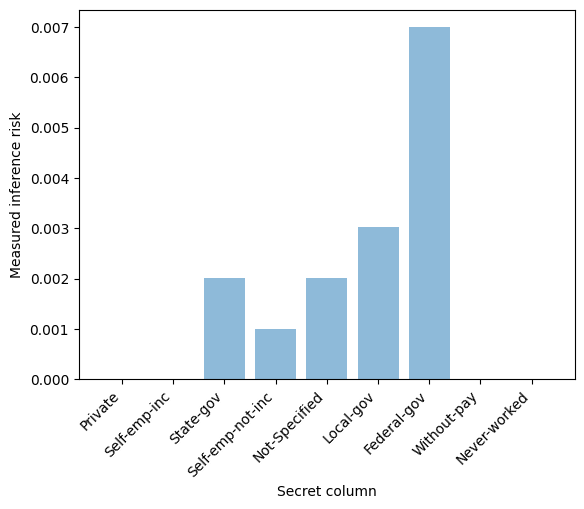

In [10]:
worklass_res = results_for_groups["Workclass"]

fig, ax = plt.subplots()

risks = [res["risk"].value for _, res in worklass_res.items()]
columns = [key for key,_ in worklass_res.items()]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

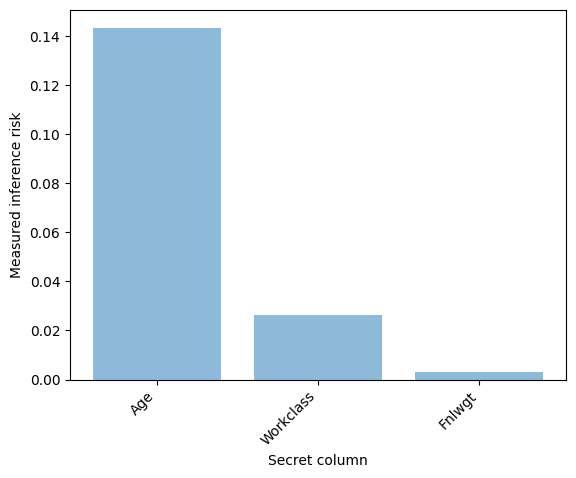

In [9]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")